<h3 style="font-family:Arial, sans-serif;">Projet : Fashion Trend Intelligence</h3>
<ul style="font-family:Arial, sans-serif; font-size:14px;">
  <li><strong>Description :</strong> <em>à rédiger</em></li>
  <li><strong>Auteur :</strong> Christophe Ringot</li>
  <li><strong>Date :</strong> 25-06-2025</li>
</ul>


1. Import des modules necessaires

In [1]:
from dotenv import load_dotenv, dotenv_values
import matplotlib.pyplot as plt
import os, io, base64, requests
from tqdm import tqdm
from PIL import Image
import numpy as np
import time

2. Chargement des variables d'environnement depuis le `.env`  

In [2]:
load_dotenv()
config = dotenv_values(".env")

3. Déclaration des variables


In [3]:
image_dir = "./assets/top_influenceurs_2024/IMG/"
mask_dir = "./assets/top_influenceurs_2024/Mask/"
max_images = 3  
api_token = os.getenv("API_TOKEN")
url = "https://api-inference.huggingface.co/models/sayeed99/segformer_b3_clothes"
headers = {
    "Authorization": f"Bearer {api_token}",
    "Content-Type": "image/png"
}
image_paths = []
mask_paths = []
combined_masks = []

4. Fonctions Utilitaires pour le Traitement des Masques

In [4]:
CLASS_MAPPING = {
    "Background": 0,
    "Hat": 1,
    "Hair": 2,
    "Sunglasses": 3,
    "Upper-clothes": 4,
    "Skirt": 5,
    "Pants": 6,
    "Dress": 7,
    "Belt": 8,
    "Left-shoe": 9,
    "Right-shoe": 10,
    "Face": 11,
    "Left-leg": 12,
    "Right-leg": 13,
    "Left-arm": 14,
    "Right-arm": 15,
    "Bag": 16,
    "Scarf": 17
}

def get_image_dimensions(img_path):
    """
    Get the dimensions of an image.

    Args:
        img_path (str): Path to the image.

    Returns:
        tuple: (width, height) of the image.
    """
    original_image = Image.open(img_path)
    return original_image.size

def decode_base64_mask(base64_string, width, height):
    """
    Decode a base64-encoded mask into a NumPy array.

    Args:
        base64_string (str): Base64-encoded mask.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Single-channel mask array.
    """
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]  # Take first channel if RGB
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def create_masks(results, width, height):
    """
    Combine multiple class masks into a single segmentation mask.

    Args:
        results (list): List of dictionaries with 'label' and 'mask' keys.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Combined segmentation mask with class indices.
    """
    combined_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize with Background (0)

    # Process non-Background masks first
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0:  # Skip Background
            continue
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id

    # Process Background last to ensure it doesn't overwrite other classes unnecessarily
    # (Though the model usually provides non-overlapping masks for distinct classes other than background)
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_base64_mask(result['mask'], width, height)
            # Apply background only where no other class has been assigned yet
            # This logic might need adjustment based on how the model defines 'Background'
            # For this model, it seems safer to just let non-background overwrite it first.
            # A simple application like this should be fine: if Background mask says pixel is BG, set it to 0.
            # However, a more robust way might be to only set to background if combined_mask is still 0 (initial value)
            combined_mask[mask_array > 0] = 0 # Class ID for Background is 0

    return combined_mask


5. Boucle pour sauvegarder le chemin de chaques images dans la liste `image_paths`

In [5]:
"""
    boucle pour parcourir les images du dossier IMG, récupère le chemin et le nom 
    de chaque image, puis ajoute le chemin complet dans la liste image_paths.
"""
for path, _, files in os.walk(image_dir):
    for file in files:
        image_paths.append(f"{path}/{file}")

# chemin des masques
for path, _, files in os.walk(mask_dir):
    for file in files:
        mask_paths.append(f"{path}/{file}")

6. Fonction pour la Ségmentation d'une liste d'image 

In [16]:
def segment_images_batch(list_of_image_paths):
    """
    Segmente une liste d'images en utilisant l'API Hugging Face.

    Args:
        list_of_image_paths (list): Liste des chemins vers les images.

    Returns:
        list: Liste des masques de segmentation (tableaux NumPy).
              Contient None si une image n'a pas pu être traitée.
    """
    batch_segmentations = []
    
    for i, image_path in tqdm(enumerate(list_of_image_paths), total=max_images, desc="Segmentation des images"):

        
        single_image_path = image_path
        print(f"Traitement de l'image : {single_image_path}")
        
        try:
            image_data = None
            
            with open(single_image_path, "rb") as data:
                image_data = data
                
                response = requests.post(url,image_data, headers=headers, timeout=15)
                
                if response.status_code != 200:
                    batch_segmentations.append(None)
                    response.raise_for_status()
                else:
                    response = response.json()               
                    width, height = get_image_dimensions(single_image_path)
                    combined_mask = create_masks(response, width, height)
                    batch_segmentations.append(combined_mask)
                    
                time.sleep(1)
        
            if i+1 == max_images:
                break

        except Exception as e:
            print(f"error : {e}")

    return batch_segmentations

In [17]:
# Appeler la fonction pour segmenter les images listées dans image_paths
if image_paths:
    print(f"\nTraitement de {len(image_paths)} image(s) en batch...")
    batch_seg_results = segment_images_batch(image_paths)
    print("Traitement en batch terminé.")
else:
    batch_seg_results = []
    print("Aucune image à traiter en batch.")


Traitement de 50 image(s) en batch...


Segmentation des images:   0%|          | 0/3 [00:00<?, ?it/s]

Traitement de l'image : ./assets/top_influenceurs_2024/IMG//image_0.png


Segmentation des images:  33%|███▎      | 1/3 [00:12<00:25, 12.59s/it]

Traitement de l'image : ./assets/top_influenceurs_2024/IMG//image_1.png


Segmentation des images:  67%|██████▋   | 2/3 [00:20<00:09,  9.81s/it]

Traitement de l'image : ./assets/top_influenceurs_2024/IMG//image_10.png


Segmentation des images:  67%|██████▋   | 2/3 [00:30<00:15, 15.13s/it]

Traitement en batch terminé.


7. Traîtement de la réponse 

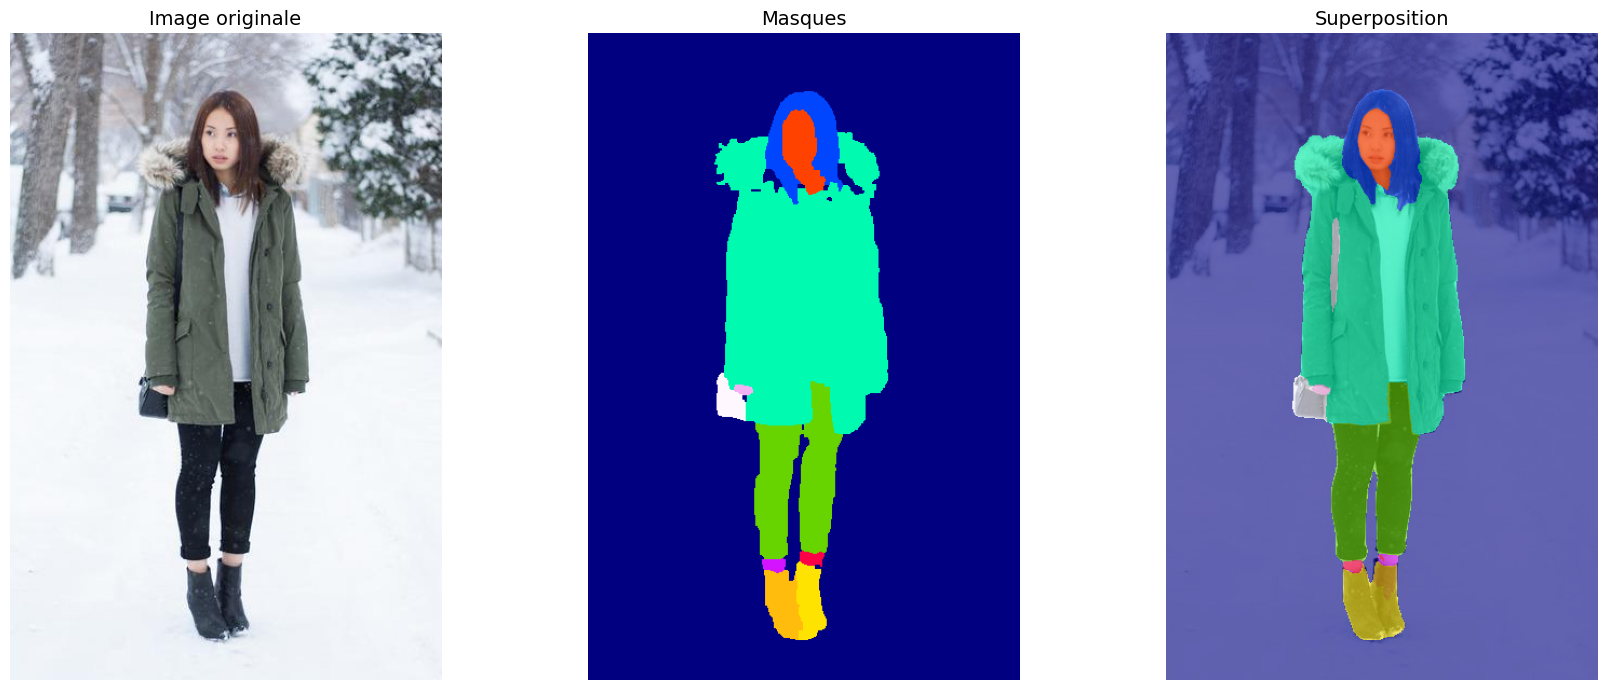

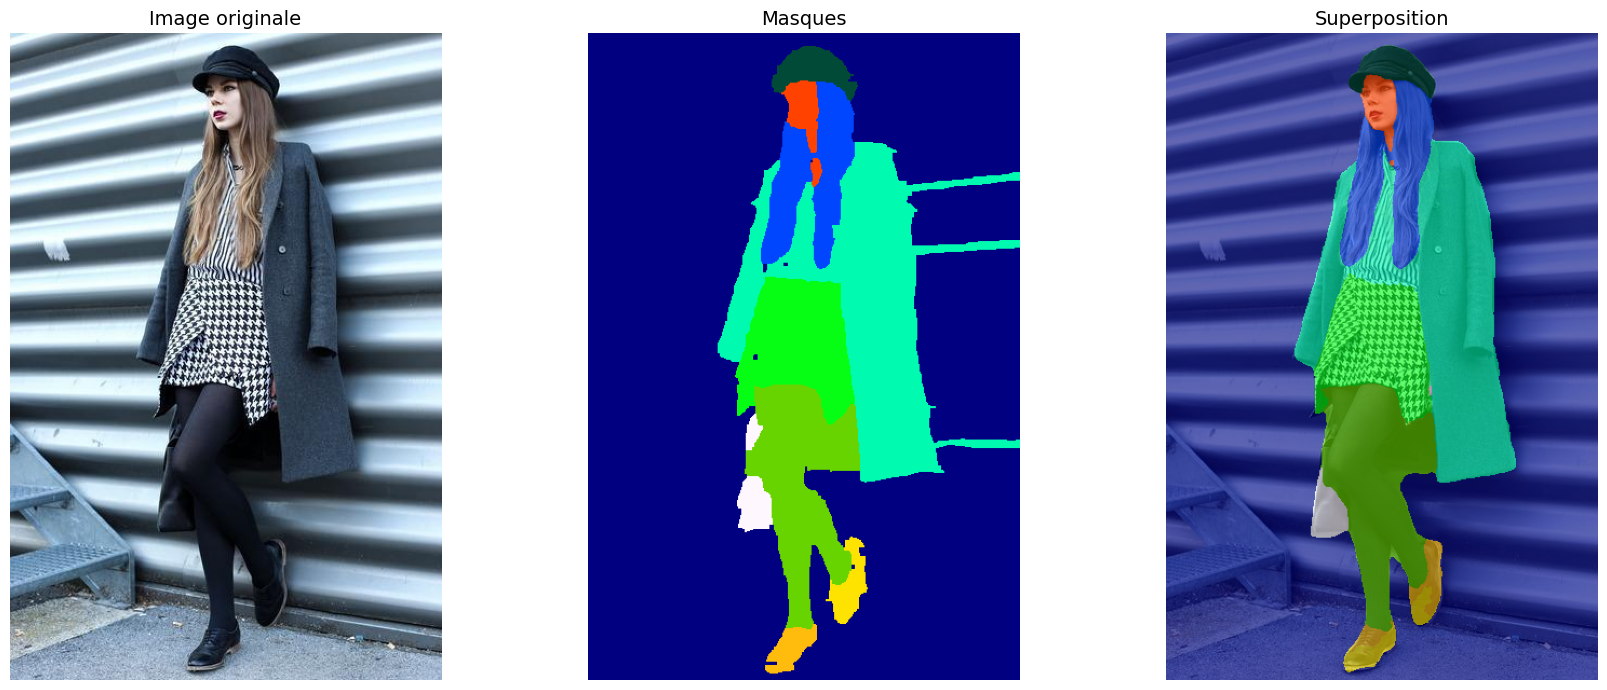

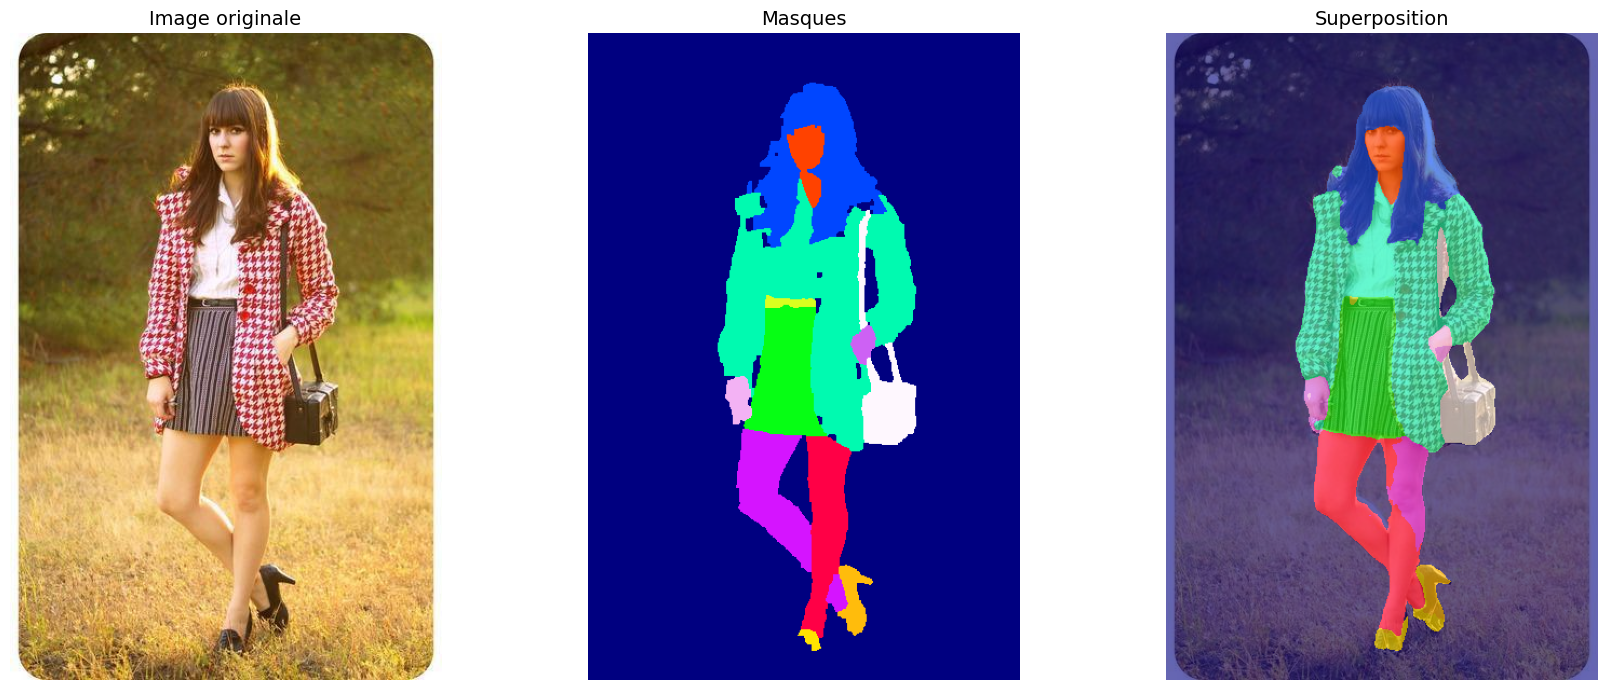

In [18]:
"""
    Ouvre l'image d'origine, puis si la réponse de l'API est une liste, 
    affiche trois visualisations : 
        - l'image originale 
        - les masques seuls
        - la superposition des masques sur l'image. 
"""

for i, combined_mask in enumerate(batch_seg_results):
    image = Image.open(image_paths[i])
    mask = Image.open(mask_paths[i])
    
    if isinstance(combined_mask, np.ndarray):

        # Crée une figure avec 1 ligne et 3 colonnes
        # figsize pour gérer la taille de l'image
        _, axs = plt.subplots(1, 3, figsize=(18, 7))

        # Image
        axs[0].imshow(image)
        axs[0].set_title("Image originale", fontsize=14)
        axs[0].axis("off")

        # Masques

        axs[1].imshow(mask, cmap="gist_ncar")
        axs[1].set_title("Masques", fontsize=14)
        axs[1].axis("off")

        # Superposition
        axs[2].imshow(image)
        axs[2].imshow(combined_mask, alpha=0.6, cmap="gist_ncar")
        axs[2].set_title("Superposition", fontsize=14)
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    else:
        print("Aucune image à traiter en batch.")